# Task 1

## Task 1.1: Derive the gradient for Logistic Regression

Using $-E^n(w) = t^n \ln(y^n) + (1 - t^n)\ln(1 - y^n)$, we take it's derivative with respect to the $j$'th weight.
$$
-\frac{\partial E^n}{\partial w_j} = \frac{\partial}{\partial w_j}\left( t^n \ln(y^n)\right) 
    + \frac{\partial}{\partial w_j}\left( (1 - t^n) \ln(1 - y^n) \right) \\
    = t^n\frac{1}{y^n}\frac{\partial y^n}{\partial w_j} + (1-t^n)\frac{1}{1-y^n}\frac{\partial (1-y^n)}{\partial w_j} \\
    = t^n\frac{1}{y^n}\frac{\partial y^n}{\partial w_j} - (1-t^n)\frac{1}{1-y^n}\frac{\partial y^n}{\partial w_j}
$$

Rewriting the hint in the assignment
$$
\frac{\partial y^n}{\partial w_j} = \frac{\partial g^n_w(x)}{\partial w_j} = x^n_j g_w^n (1 - g^n_w) = x^n_j y^n (1 - y^n)
$$

Inserting this into the equation above gives
$$
-\frac{\partial E^n}{\partial w_j} 
= t^n\frac{1}{y^n}\frac{\partial y^n}{\partial w_j} - (1-t^n)\frac{1}{1-y^n}\frac{\partial y^n}{\partial w_j} \\
= t^n\frac{1}{y^n}x^n_j y^n (1 - y^n) - (1-t^n)\frac{1}{1-y^n}x^n_j y^n (1 - y^n) \\
= t^n x^n_j - t^n x^n_j y^n - x^n_j y^n +t^n x^n_j y^n \\
= (t^n - y^n) x^n_j
$$

## Task 1.2: Derive the gradient for Softmax Regression

# Task 2

## Task 2.1: Logistic Regression through gradient descent

#### Load data and Preprocessing

Label: 2


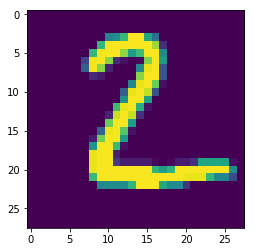

In [1]:
import mnist
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

import time

try:
    X_train, Y_train, X_test, Y_test = mnist.load()
except FileNotFoundError:
    mnist.init()
    X_train, Y_train, X_test, Y_test = mnist.load()

N_train = 20000
N_test = 2000
N_batches = 20

def add_bias_term(X):
    (n,d) = X.shape
    return np.hstack( (X, np.ones((n,1)) ) )

def category_filter(X, Y, yes, no):
    assert yes != no
    mask = np.any([[Y==yes],[Y==no]], axis=0)[0]
    Y[Y==yes] = 1
    Y[Y==no] = 0
    
    X = X[mask,...]
    Y = Y[mask,...]
    
    trues = len([b for b in mask if b])
    assert trues == len(X)
    assert trues == len(Y)
    return X,Y

def do_preprocessing(X,Y,limit=None, limit_method='random'):
    assert len(X) == len(Y)
    X = add_bias_term(X)
    X,Y = category_filter(X,Y,yes=2,no=3)
    
    X = X/256.0
    if limit is not None:
        limit = min(limit, len(X))
        if limit_method == 'random':
            mask = random.sample(range(len(X)), limit)
            X = X[mask]
            Y = Y[mask]
        elif limit_method == 'first':
            X = X[:limit]
            Y = Y[:limit]
        elif limit_method == 'last':
            X = X[~limit+1:]
            Y = Y[~limit+1:]
        else:
            raise ValueError(limit_method + " is not a valid limit method")
    
            
    
    
    return X, Y

X_train, Y_train = do_preprocessing(X_train,Y_train, limit=N_train, limit_method='first')
X_test, Y_test = do_preprocessing(X_test,Y_test,limit=N_test, limit_method='first')

X_train = X_train[:(len(X_train)//N_batches)*N_batches]
X_test = X_test[:(len(X_test)//N_batches)*N_batches]
Y_train = Y_train[:(len(Y_train)//N_batches)*N_batches]
Y_test = Y_test[:(len(Y_test)//N_batches)*N_batches]



# ------ manual check ------
checkimage = np.reshape(X_test[0][:~0], (28,28))
checklabel = 2 if Y_test[0]==1 else 3
plt.imshow(checkimage)
print("Label:", checklabel)

#### Training

Batch size: 1000
Epoch   100 complete: Training loss 0.077, Validation loss 0.052, Test loss 0.062, alpha (% of initial) 50.2513%
Epoch   200 complete: Training loss 0.074, Validation loss 0.051, Test loss 0.061, alpha (% of initial) 33.4448%
Epoch   300 complete: Training loss 0.073, Validation loss 0.051, Test loss 0.061, alpha (% of initial) 25.0627%
Early stop at epoch 387
------ Training results ------
Train loss: 0.07171689792385796
Validation loss: 0.05096410357715726
Test loss: 0.060509740662444446


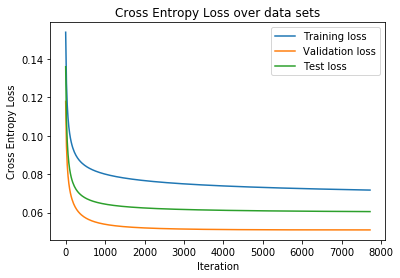

In [2]:
max_epochs = 50000

T_anneal = 100
alpha_initial = 0.0005
use_annealing_learning_rate = True
early_stop_increase_length = 5

def sigmoid(z):
    return 1.0/(1 + np.exp(-z))

def cross_entropy_loss(target, output):
    assert target.shape == output.shape
    N = len(target)
    assert N > 0
    E = -(np.dot(target,np.log(output)) + np.dot(1-target, np.log(1-output)))/N
    assert E >= 0, "{0} is not >= 0,".format(E)
    return E

def logistic_regression_gradient(data_series, target, output):
    assert target.shape == output.shape, \
        "target.shape={0}, output.shape={1}".format(target.shape, output.shape)
    assert data_series.shape[1] == target.shape[0]
    
    return np.dot(data_series, output - target)

def network_output(data_series,weights):
    (n,d) = data_series.shape
    assert d == weights.shape[0], \
        "mismatched dimensions: data_series.shape={0}, weights.shape={1}".format(data_series.shape, weights.shape)
    #print("presigmoid:", np.dot(data_series, weights))
    return sigmoid(np.dot(data_series, weights))

def predict_from_output(output):
    mask = output >= 0.5
    return np.where(mask, np.ones_like(mask), np.zeros_like(mask))

def predict_from_input(X, weights):
    return predict_from_output(network_output(X,weights))

def compute_cross_entropy_loss(X, Y, weights):
    Y_network = network_output(X, weights)
    return cross_entropy_loss(Y, Y_network)

def compute_batched_cross_entropy_loss(X_batches, Y_batches, weights):
    assert (X_batches.shape[0] == Y_batches.shape[0]) and (X_batches.shape[1] == Y_batches.shape[1]), \
        "Dimension mismatch for X_batches {0} and Y_batches {1}".format(X_batches.shape, Y_batches.shape)
    
    loss = sum([compute_cross_entropy_loss(X, Y, weights) for (X, Y) in zip(X_batches, Y_batches)])
    
    return loss/len(X_batches)


def compute_percentage_correct(Y_correct, Y_predict):
    assert Y_correct.shape == Y_predict.shape
    #predictions = predict_from_output(Y_output)
    correct = Y_correct == Y_predict
    return np.count_nonzero(correct)/len(correct)

def compute_batched_percentage_correct(X_batches, weights, Y_correct_batches):
    assert len(X_batches) == len(Y_correct_batches)
    percentage_correct = 0
    for (X,Y) in zip(X_batches, Y_correct_batches):
        Y_predict = predict_from_input(X, weights)
        percentage_correct += compute_percentage_correct(Y, Y_predict)
    
    return percentage_correct/len(X_batches)


assert N_train % N_batches == 0, "N_batches {0} does not divide N_train {1}".format(N_batches, N_train)

batch_size = int(N_train/N_batches)
print("Batch size:", batch_size)
X_batches = np.array(np.split(X_train, N_batches))
Y_batches = np.array(np.split(Y_train, N_batches))

# Split into training and validation set
X_train_batches, X_validate_batches = X_batches[:~1], X_batches[~1:]
Y_train_batches, Y_validate_batches = Y_batches[:~1], Y_batches[~1:]

w_dim = X_train.shape[1]
weights = np.zeros(w_dim)

train_loss = []
validate_loss = []
test_loss = []
train_percentage_correct = []
validate_percentage_correct = []
test_percentage_correct = []

best_validation_weights = [float('inf'), weights]
epoch = 1
while epoch < max_epochs:
    t = epoch - 1
    if use_annealing_learning_rate:
        alpha = alpha_initial/(1 + t/T_anneal)
    else:
        alpha = alpha_initial
    
    # Feed forward and backpropagation
    for (X,Y) in zip(X_train_batches, Y_train_batches):
        Y_predict = network_output(X, weights)
        gradient = logistic_regression_gradient(np.transpose(X), Y, Y_predict)
        weights -= alpha*gradient
    
    # Loss calculations
    train_loss.append(compute_batched_cross_entropy_loss(X_train_batches, Y_train_batches, weights))
    validate_loss.append(compute_batched_cross_entropy_loss(X_validate_batches, Y_validate_batches, weights))
    test_loss.append(compute_cross_entropy_loss(X_test, Y_test, weights))
    
    # Correct calculations
    train_percentage_correct.append(compute_batched_percentage_correct(X_train_batches, weights, Y_train_batches))
    validate_percentage_correct.append(compute_batched_percentage_correct(X_validate_batches, weights, Y_validate_batches))
    test_percentage_correct.append(compute_percentage_correct(Y_test, predict_from_input(X_test, weights)))
    
    
    if validate_loss[~0] < best_validation_weights[0]:
        best_validation_weights[0] = validate_loss[~0]
        best_validation_weights[1][:] = weights
    
    if epoch % 100 == 0:
        status_str = "Epoch {:5d} complete: ".format(epoch)
        status_str += "Training loss {:.3f}, ".format(train_loss[~0])
        status_str += "Validation loss {:.3f}, ".format(validate_loss[~0])
        status_str += "Test loss {:.3f}, ".format(test_loss[~0]) 
        status_str += "alpha (% of initial) {:.4%}".format(alpha/alpha_initial)
        print(status_str)
    
    if len(validate_loss) >= early_stop_increase_length:
        validate_tail_diff = np.diff(validate_loss[~early_stop_increase_length:])
        validate_loss_increase = (validate_tail_diff >= 0.0).all()
        
        if validate_loss_increase:
            print("Early stop at epoch {}".format(epoch))
            break
    
    assert len(train_loss) == len(validate_loss) and len(validate_loss) == len(test_loss) and \
        len(train_percentage_correct) == len(train_loss) and len(validate_percentage_correct) == len(train_loss) and \
        len(test_percentage_correct) == len(train_percentage_correct)
    epoch += 1

print("------ Training results ------")
weights[:] = best_validation_weights[1]
print("Train loss:", compute_batched_cross_entropy_loss(X_train_batches, Y_train_batches, weights))
print("Validation loss:", compute_batched_cross_entropy_loss(X_validate_batches, Y_validate_batches, weights))
print("Test loss:", compute_cross_entropy_loss(X_test, Y_test, weights))

# Analysis
t = N_batches*np.array(range(len(train_loss)))
plt.plot(t, train_loss, label="Training loss")
plt.plot(t, validate_loss, label="Validation loss")
plt.plot(t, test_loss, label="Test loss")
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Iteration")
plt.title("Cross Entropy Loss over data sets")
plt.legend()
plt.show()

#### a

##### Vectorization of the update law
The code uses a vectorized version of the gradient descent update law. To arrive at it we define $T = \left( t^1, t^2, ... t^N \right)^T$ and $Y = \left( y^1, y^2, ... y^N \right)^T$, where $N$ is the batch size. 

Also we take the data from a batch and put it into a $(d+1)\times N$ matrix called $X$, with each image going into a column of $X$. 

The gradient is given by
$$
\nabla_w E = 
\begin{bmatrix}
    \frac{\partial E^1}{\partial w_1} +  \cdots + \frac{\partial E^N}{\partial w_1} \\
    \vdots \\
    \frac{\partial E^1}{\partial w_{d+1}} + \cdots + \frac{\partial E^N}{\partial w_{d+1}}
\end{bmatrix}
=
-\begin{bmatrix}
    x_1^1(t^1 - y^1) +  \cdots + x_1^N(t^N - y^N) \\
    \vdots \\
    x_{d+1}^1(t^1 - y^1) +  \cdots + x_{d+1}^N(t^N - y^N) 
\end{bmatrix}
= - X (T - Y)
$$

##### Does the validation set work as a good stand-in for the test-set?
The validation set solves the problem of data-snooping on the test set by taking a small portion of the training set and using it to evaluate the networks performance. If we can be sure that the validation set has many of the same properties as the test set, which is reasonable if the training set has many of the same properties as the test set, then it can function as a good stand in for the test set. 



#### b

The plot below show the accuracy on the different sets and how they changed over time. As expected the training set has the highest accuracy. I would've expected the validation set to have the second highest and then the test set to have the lowest, but this is not what we see. From playing around with different ways of drawing from the MNIST dataset (taking the first, last, or a random sampling), this order seems to change from time to time, but most often it is like this. The test set is the last few thousand images from the MNIST dataset, which should be difficult, while the training and validation set is the first thousands of images, which should be easy. 

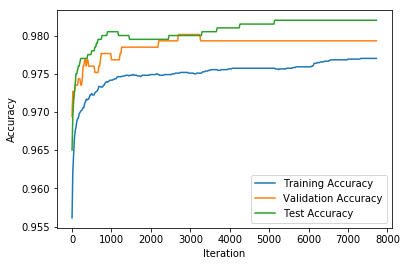

In [3]:
plt.plot(t, train_percentage_correct, label="Training Accuracy")
plt.plot(t, validate_percentage_correct, label="Validation Accuracy")
plt.plot(t, test_percentage_correct, label="Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Iteration")
plt.legend()
plt.show()

## Task 2.2: Regularization
#### a

For $L_2$ regularization, we can rewrite $C(w)$ as $C(w) = w^Tw$.
Then it is clear that its gradient is given by
$$
    \frac{\partial C}{\partial w} = 2 w
$$

With this form regularization, the update term for logistic regresion becomes
$$
    \frac{\partial J^n}{\partial w_j} = -x^n (t^n - y^n) + \lambda 2 w_j
$$
Vectorizing it, we have
$$
    \frac{\partial J}{\partial w} = -X(T-Y) + \lambda 2w
$$

#### b


{'accuracy': <Figure size 432x288 with 1 Axes>,
 'norm': <Figure size 432x288 with 1 Axes>}

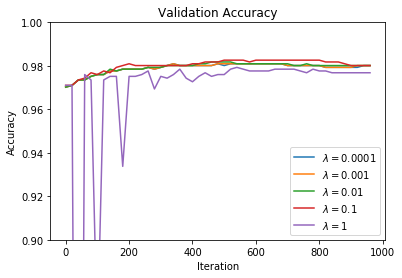

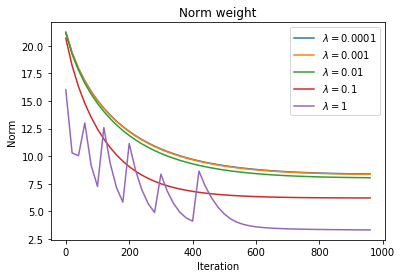

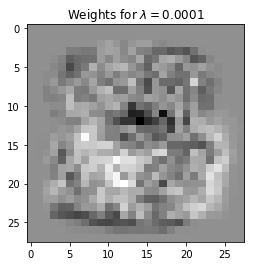

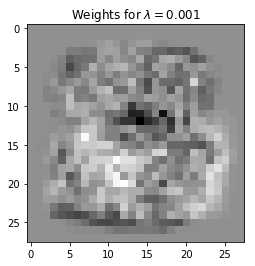

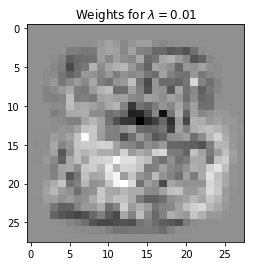

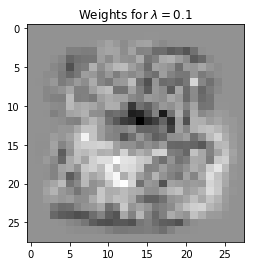

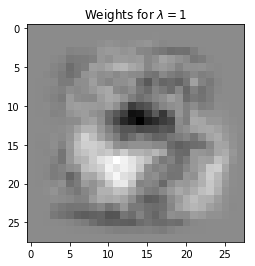

In [28]:
def logistic_regression_gradient_with_l2_regularization(data_series, target, output, l2_weight, weights):
    return logistic_regression_gradient(data_series, target, output) + 2*l2_weight*weights

def training_subroutine(plot_handle, l2_weight):
    max_epochs = 50

    T_anneal = 10
    alpha_initial = 0.01
    use_annealing_learning_rate = True
    early_stop_increase_length = 5
    
    w_dim = X_train.shape[1]
    weights = np.zeros(w_dim)
    
    validate_accuracy = []
    weights_length = []

    best_validation_weights = [float('inf'), weights]
    epoch = 1
    while epoch < max_epochs:
        t = epoch - 1
        if use_annealing_learning_rate:
            alpha = alpha_initial/(1 + t/T_anneal)
        else:
            alpha = alpha_initial

        # Feed forward and backpropagation
        for (X,Y) in zip(X_train_batches, Y_train_batches):
            Y_predict = network_output(X, weights)
            gradient = logistic_regression_gradient_with_l2_regularization(np.transpose(X), Y, Y_predict, l2_weight, weights)
            weights -= alpha*gradient

        # Accuracy/Loss calculations
        #validate_loss.append(compute_batched_cross_entropy_loss(X_validate_batches, Y_validate_batches, weights))
        validate_accuracy.append(compute_batched_percentage_correct(X_validate_batches, weights, Y_validate_batches))
        weights_length.append(np.linalg.norm(weights))
        
        #if validate_loss[~0] < best_validation_weights[0]:
        #    best_validation_weights[0] = validate_loss[~0]
        #    best_validation_weights[1][:] = weights

        '''
        if len(validate_loss) >= early_stop_increase_length:
            validate_tail_diff = np.diff(validate_loss[~early_stop_increase_length:])
            validate_loss_increase = (validate_tail_diff >= 0.0).all()

            if validate_loss_increase:
                print("Early stop at epoch {}".format(epoch))
                break
    '''
        epoch += 1

    # Analysis
    if plot_handle is None:
        plot_handle = {}
        plt.figure()
        plot_handle['accuracy'] = plt.gcf()
        plt.figure()
        plot_handle['norm'] = plt.gcf()
        
    plt.figure(plot_handle['accuracy'].number)
    t = N_batches*np.array(range(len(weights_length)))
    plt.plot(t, validate_accuracy, label="$\lambda = {}$".format(l2_weight))
    plt.ylabel("Accuracy")
    plt.ylim((0.9,1.0))
    plt.xlabel("Iteration")
    plt.title("Validation Accuracy")
    plt.legend()
    
    plt.figure(plot_handle['norm'].number)
    plt.plot(t, weights_length, label="$\lambda = {}$".format(l2_weight))
    plt.ylabel("Norm")
    plt.xlabel("Iteration")
    plt.title("Norm weight")
    plt.legend()
    
    
    plt.figure()
    checkimage = np.reshape(weights[:~0], (28,28))
    plt.imshow(checkimage, cmap='gray')
    plt.title("Weights for $\lambda = {}$".format(l2_weight))
    return plot_handle
    
plot_handle = training_subroutine(plot_handle=None, l2_weight=0.0001)
training_subroutine(plot_handle=plot_handle, l2_weight=0.001)
training_subroutine(plot_handle=plot_handle, l2_weight=0.01)
training_subroutine(plot_handle=plot_handle, l2_weight=0.1)
training_subroutine(plot_handle=plot_handle, l2_weight=1)

#### c
#### d

# Task 3
#### a
#### b
#### c
#### d

# Task 4
#### a
#### b